# Orquestrador de Chatbots - Exploração do Problema
-----------------------------------

Esse notebook foi utilizado na exploração do problema, e as soluções aqui encontradas foram então transportadas para outros módulos, de forma mais organizada e sucinta.

# Bibliotecas utilizadas

In [354]:
import pandas as pd
import numpy as np
import csv

from nltk.tokenize import RegexpTokenizer
import nltk
from nltk.corpus import stopwords
from string import punctuation

import re

from unicodedata import normalize

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, make_scorer

from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from xgboost import  XGBClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB

from sklearn.ensemble import VotingClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Funções

In [355]:
def remover_tags_html(texto):
    clean = re.compile('<.*?>')
    return re.sub(clean, ' ', texto)

In [356]:
# Realiza uma limpeza básica de um texto, preparando-o para classificação. 
def limpar_texto(texto):

    # Converte para minúsculas
    texto = texto.lower()
    
    # Remove acentos
    texto = normalize('NFKD', texto).encode('ASCII', 'ignore').decode('ASCII')
    
    texto = remover_tags_html(texto)  
    
    # Remove caracteres especiais e números
    texto = re.sub(r'[^a-zA-Z_]',' ',texto)
    
    # Remove Tags HTML
    texto = remover_tags_html(texto)  
    
    # Remove URLs
    texto = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', ' ', texto, flags=re.MULTILINE)
    
    # Remove emails   
    texto = re.sub(r'[\w\.-]+@[\w\.-]+(\.[\w]+)+', ' ', texto, flags=re.MULTILINE)  
    
    # Remove um caso comum de apóstrofo 
    texto = texto.replace("d'", " ") 
    
    # Remove espaços extras e palavras menores do que um tamanho mínimo
    tokens = tokenizer.tokenize(texto)
    tokens = [palavra for palavra in tokens if len(palavra) > 1]          
    tokens = [palavra for palavra in tokens if palavra not in lista_stopwords] 
    
    if usar_stemmer:
        for i in range(len(tokens)):
            token = stemmer.stem(tokens[i])
            tokens[i] = token 
            
    texto = ' '.join(tokens)  
    
    return texto

In [357]:
# Calcula métricas de desempenho do classificador.
def get_metrics(y_test, y_predicted, decimais=4): 
    
    accuracy = round(accuracy_score(y_test, y_predicted),decimais)
    
    precision = round(precision_score(y_test, y_predicted, pos_label=1, average='macro', zero_division=0),decimais)             
    recall = round(recall_score(y_test, y_predicted, pos_label=1, average='macro', zero_division=0),decimais) 
    f1_macro = round(f1_score(y_test, y_predicted, pos_label=1, average='macro', zero_division=0),decimais)
    f1_weighted = round(f1_score(y_test, y_predicted, pos_label=1, average='weighted', zero_division=0),decimais)
 
    print('Acurácia:',accuracy,'- Precisão (Macro):',precision,'- Recall (Macro):',recall,
          '- F1 (Macro):',f1_macro, '- F1 (Weighted):',f1_weighted,)
    
    return accuracy, precision, recall, f1_macro

In [358]:
def executa_grid_search(param_grid, clf, X_GS,  y_GS, vectorizer, scoring='f1_macro'):
    classif_pipe = Pipeline([('vectorize', vectorizer),
                           ('classifier', clf)])  
    grid_search = GridSearchCV(classif_pipe, param_grid, cv=3, n_jobs=-1, verbose=3, 
                               scoring=scoring)
    grid_search.fit(X_GS, y_GS)
    results = pd.DataFrame(grid_search.cv_results_)
    results.sort_values(by='rank_test_score', inplace=True)
    results.reset_index(inplace=True)
    
    print(grid_search.best_estimator_['classifier'].__class__.__name__,
          '- Média Score:',results.iloc[0]['mean_test_score'],
          '\nParams:',results.iloc[0]['params'])
    
    return grid_search.best_estimator_, results

In [359]:
def gerar_voting(clfs_selec, clfs_base, voting='soft'):
    estimators =[]
    for clf in clfs_base:
        if clf.__class__.__name__ in clfs_selec:
            if (voting=='soft') and (clf.__class__.__name__ in ['LinearSVC','SGDClassifier']):
                estimators.append((clf.__class__.__name__, CalibratedClassifierCV(clf, method='sigmoid', cv=3)))
            else:
                estimators.append((clf.__class__.__name__, clf))
                        
    voting_clf = VotingClassifier(estimators=estimators, n_jobs=-1, voting=voting)
    return voting_clf

# Inicialização

### Chatbots Disponívels para Treinamento

A seguir a relação dos chatbots disponibilizados.

O "*id*"  é o identificador do chatbot. 

O identificador **0** (zero) deverá ser atribuído às perguntas que forem consideradas como **não** direcionadas a nenhum dos bots abaixo. Tais perguntas existirão apenas no arquivo de validação, sem rótulos.

In [360]:
bots = [
    {'id':0, 'nome':'Nenhum'},
    {'id':1, 'nome':'Alistamento Militar'},
    {'id':2, 'nome':'COVID'},
    {'id':3, 'nome':'Login Único'},
    {'id':4, 'nome':'IRPF - Perguntão 2020'},
    {'id':5, 'nome':'PGMEI - Programa Gerador de DAS do Microempreendedor Individual'},
    {'id':6, 'nome':'POC Selo Turismo Responsável'},
    {'id':7, 'nome':'Cadastur - Cadastro dos Prestadores de Serviços Turísticos'},
    {'id':8, 'nome':'Tuberculose'}
]

### Semente Aleatória

Semente aleatória a ser usada ao longo desse notebook.

In [361]:
random_state= 112020

### Stemmer?
Indica se será usado stemmer na preparação dos dados. Os melhores resultados têm ocorrido com a aplicação de stemmer.

In [362]:
usar_stemmer=True

### Nomes dos Arquivos Utilizados

Nomes dos arquivos que serão utilizados ao longo deste notebook.

In [363]:
# Nome do arquivo onde estão armazenadas as perguntas rotuladas, para treino e teste.
arquivo_treino_testes = 'treino_testes.csv'

# Nome do arquivo onde estão armazenadas as perguntas de validação, não rotuladas, para classificação.
# Cada pergunta aqui conterá um identificador que deverá ser mantido.
# Este arquivo irá validar quão bons, de fato, os classificadores são.
# Ele inclusive possui perguntas fora do contextos dos bots relacionados.
arquivo_validacao_sem_rotulos = 'validacao_sem_rotulos.csv'

# Nome do arquivo que será criado com as perguntas de validação rotuladas pelos classificadores.
# Ele deverá conter apenas os identificadores das perguntas e os identificadores dos respectivos bots.
arquivo_validacao_classificado = 'validacao_classificado.csv'

# Nome do arquivo com os rótulos reais das perguntas de validação, para conferência do desempenho final dos classificadores.
arquivo_validacao_verdade = 'validacao_verdade.csv'

# Carregar e preparar os dados

In [364]:
# Carrega o arquivo CSV
df = pd.read_csv(arquivo_treino_testes, index_col=None, engine='python', sep =',', encoding="utf-8")
print('Total de registros carregados:',len(df))

# Exibe uma amostra dos dados carregados
df.tail(-1)

Total de registros carregados: 2650


,bot_id,pergunta
1,8,aperto de mao transmite tuberculose
2,6,A DIÁRIA TERÁ UM VALOR MAIOR para quem aderir ...
3,3,preciso de uma conta de acesso no login unico
4,3,Como resolver problema de CPF inválido ?
5,4,tive perda total do carro como declarar recebi...
...,...,...
2645,4,filho como dependente
2646,4,o contribuinte esta obrigado ao preenchimento ...
2647,5,Preciso imprimir a guia MEI em atraso. Como faço?
2648,7,o quer dizer CNAE


In [365]:
# Distribuição das classes nos dados fornecidos. Note que não há nenhum pergunta rotulada como "0".
totais = df.bot_id.value_counts()
for bot in bots:
    if bot['id'] == 0:
        continue
    bot['total'] = totais[bot['id']]
bots

[{'id': 0, 'nome': 'Nenhum'},
 {'id': 1, 'nome': 'Alistamento Militar', 'total': 237},
 {'id': 2, 'nome': 'COVID', 'total': 116},
 {'id': 3, 'nome': 'Login Único', 'total': 292},
 {'id': 4, 'nome': 'IRPF - Perguntão 2020', 'total': 1202},
 {'id': 5,
  'nome': 'PGMEI - Programa Gerador de DAS do Microempreendedor Individual',
  'total': 72},
 {'id': 6, 'nome': 'POC Selo Turismo Responsável', 'total': 389},
 {'id': 7,
  'nome': 'Cadastur - Cadastro dos Prestadores de Serviços Turísticos',
  'total': 191},
 {'id': 8, 'nome': 'Tuberculose', 'total': 151}]

In [366]:
# Limpa os dados, preparando-os para classificação.tokenizer = RegexpTokenizer(r'\w+')
tokenizer = RegexpTokenizer(r'\w+')
stemmer = nltk.stem.RSLPStemmer()
lista_stopwords = set(stopwords.words('portuguese') + list(punctuation))
df['pergunta'] = df['pergunta'].apply(limpar_texto)
df.tail(-1)

,bot_id,pergunta
1,8,apert mao transmit tuberculos
2,6,di ter val mai ader sel tur responsa
3,3,precis cont acess login unic
4,3,resolv problem cpf inval
5,4,perd total carr declar receb segur
...,...,...
2645,4,filh depend
2646,4,contribuint obrig preench numer recib
2647,5,precis imprim gui mei atras fac
2648,7,qu diz cna


# Vocabulário (Opcional)

Infelizmente remover palavras pouco frequentes do vocabulário não ajudou no resultado final, então essa parte não está sendo feita.

In [367]:
vocabulario = None
gerar_vocabulario = True
frequencia_minima = 2

In [368]:
if gerar_vocabulario:
    df["tokens"] = df["pergunta"].apply(tokenizer.tokenize)
    freq_doc = dict()
    vocab = dict()

    print("\nINÍCIO CONSTRUÇÃO VOCABULÁRIO.")
    for index in range(len(df)):
        tokens = df.at[index,'tokens']
        for token in tokens:
            if token in vocab:
                vocab[token] += 1
            else:
                vocab[token] = 1
        for token in set(tokens):
            if token in freq_doc:
                freq_doc[token] += 1
            else:
                freq_doc[token] = 1
    print("\nFIM CONSTRUÇÃO VOCABULÁRIO.\n")

    print('Tamanho Vocabulário:',str(len(vocab)))
    
    # Removendo termos infrequentes.
    print('Removendo termos infrequentes...')
    vocab_df = pd.DataFrame({'palavra': list(vocab.keys()), 'frequencia': list(vocab.values())})
    vocabulario = list(vocab.keys())
    vocabulario.sort()
    vocab_remover = list(vocab_df[vocab_df['frequencia'] < frequencia_minima]['palavra'])
    vocabulario = [p for p in vocabulario if p not in vocab_remover]
    print("Tamanho do vocabulário após remoção de palavras infrequentes: " + str(len(vocabulario)))
    
    # Adequando texto ao vocabulário
    #for index in range(len(df)):
    #    tokens = tokenizer.tokenize(df.at[index,'pergunta'])
    #    tokens = [palavra for palavra in tokens if palavra in vocabulario]
    #    df.at[index,'pergunta'] = ' '.join(tokens)
    #print('Textos foram adaptados ao vocabulário')


INÍCIO CONSTRUÇÃO VOCABULÁRIO.

FIM CONSTRUÇÃO VOCABULÁRIO.

Tamanho Vocabulário: 1495
Removendo termos infrequentes...
Tamanho do vocabulário após remoção de palavras infrequentes: 939


# Vetorizador TF-IDF

In [369]:
if vocabulario == None:
    vectorizer = TfidfVectorizer(ngram_range=(1,2), sublinear_tf=True, smooth_idf=False, vocabulary=vocabulario, norm='l2')
else:
    vectorizer = TfidfVectorizer(ngram_range=(1,2), vocabulary=vocabulario)
vectorizer.fit_transform(df['pergunta'].tolist())
print(vectorizer)

TfidfVectorizer(ngram_range=(1, 2),
                vocabulary=['abat', 'acab', 'aceit', 'acess', 'ach', 'acid',
                            'acion', 'aco', 'acompanh', 'acontec', 'acord',
                            'acoug', 'acresc', 'ader', 'adesa', 'adi', 'adiant',
                            'adic', 'adoca', 'adolesc', 'adot', 'adquir',
                            'aeronau', 'aeronav', 'afet', 'agenc', 'agir',
                            'agor', 'agu', 'aid', ...])


# Obter Parametrização dos Classificadores Base com Grid Search

Procura melhores parâmetros para (alguns) os clssificadores base que irão compor o VotingClassifier.

A cada GridSearch, é armazenado o melhor classificador obtido. Esses classificadores irão compor a base do Voting,

Como não teremos um Voting multiclasse, mas vários Votings específicos por classe, o ideal é que os gridsearches também fossem por classe, gerando parâmetros otimizados dos classificadores base também por classe. Mas como isso vai aumentar consideravelmente a complexidade da solução, ficará para um segundo momento. Neste momento, é escolhida uma das classes para fazer uma abordagem OVR. Se não for escolhido um bot_id, o Grid Search é realizado com todas as classes.

In [370]:
bot_id_gs = 0 # Se = 0, usa todas as classes (multiclasse). Obs: 4 = IRPF
if bot_id_gs != 0:
    df['classe'] = df['bot_id'].apply(lambda x : 1 if x == bot['id'] else 0)
    y_GS = df['classe'].tolist()
else:
    y_GS = df['bot_id'].tolist()

X_GS = df['pergunta'].tolist()
clfs_base = []
scores={}

### Grid Search LogisticRegression

In [371]:
param_grid = {'classifier__solver' : ['liblinear', 'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
              'classifier__penalty' : ['l1', 'l2'],
              'classifier__C' : [0.001, 0.01, 0.1, 0.5, 1, 1.2, 1.5, 2, 3.5, 5]
            }
clf = LogisticRegression(random_state=random_state, max_iter=1000, class_weight='balanced')
estimator, results = executa_grid_search(param_grid, clf, X_GS,  y_GS, vectorizer)
clfs_base.append(estimator['classifier'])
scores[estimator['classifier'].__class__.__name__] = results.iloc[0]['mean_test_score']
results.head(5)

Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:    7.1s


LogisticRegression - Média Score: 0.8842034258318376 
Params: {'classifier__C': 5, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}


[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   13.2s finished


,index,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__C,param_classifier__penalty,param_classifier__solver,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,117,0.042174,0.000943,0.012836,0.000624,5,l2,liblinear,"{'classifier__C': 5, 'classifier__penalty': 'l...",0.883938,0.872263,0.896409,0.884203,0.009860,1
1,114,0.041340,0.000236,0.012669,0.000472,5,l2,liblinear,"{'classifier__C': 5, 'classifier__penalty': 'l...",0.883938,0.872263,0.896409,0.884203,0.009860,1
2,102,0.041507,0.000409,0.012336,0.000472,3.5,l2,liblinear,"{'classifier__C': 3.5, 'classifier__penalty': ...",0.875876,0.874494,0.897619,0.882663,0.010590,3
3,105,0.044674,0.003092,0.013169,0.000624,3.5,l2,liblinear,"{'classifier__C': 3.5, 'classifier__penalty': ...",0.875876,0.874494,0.897619,0.882663,0.010590,3
4,103,0.131023,0.004547,0.013169,0.000850,3.5,l2,newton-cg,"{'classifier__C': 3.5, 'classifier__penalty': ...",0.882101,0.872788,0.893027,0.882639,0.008271,5


### Grid Search SGD

In [372]:
param_grid = {'classifier__max_iter': [10,20,35,50,100],
              'classifier__loss':['hinge','log','squared_hinge','modified_huber','perceptron'],
              'classifier__penalty':['l2', 'l1', 'elasticnet'],
              'classifier__alpha': [0.0001, 0.0005, 0.0007, 0.0009, 0.001, 0.0015]
             }
clf = SGDClassifier(n_jobs=-1, random_state=random_state, class_weight='balanced')
estimator, results = executa_grid_search(param_grid, clf, X_GS,  y_GS, vectorizer)
clfs_base.append(estimator['classifier'])
scores[estimator['classifier'].__class__.__name__] = results.iloc[0]['mean_test_score']
results.head(5)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 3 folds for each of 450 candidates, totalling 1350 fits


[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 1120 tasks      | elapsed:   24.2s


SGDClassifier - Média Score: 0.8878669448927458 
Params: {'classifier__alpha': 0.001, 'classifier__loss': 'modified_huber', 'classifier__max_iter': 10, 'classifier__penalty': 'elasticnet'}


[Parallel(n_jobs=-1)]: Done 1350 out of 1350 | elapsed:   28.6s finished
C:\Users\Guilherme\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


,index,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__alpha,param_classifier__loss,param_classifier__max_iter,param_classifier__penalty,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,347,0.127355,0.002249,0.008502,4.088027e-04,0.001,modified_huber,10,elasticnet,"{'classifier__alpha': 0.001, 'classifier__loss...",0.883619,0.879639,0.900343,0.887867,0.008970,1
1,356,0.130689,0.002897,0.008002,3.893359e-07,0.001,modified_huber,50,elasticnet,"{'classifier__alpha': 0.001, 'classifier__loss...",0.880168,0.879342,0.901259,0.886923,0.010143,2
2,353,0.128523,0.002041,0.009335,1.027251e-03,0.001,modified_huber,35,elasticnet,"{'classifier__alpha': 0.001, 'classifier__loss...",0.880168,0.879342,0.901259,0.886923,0.010143,2
3,350,0.129689,0.003275,0.008001,0.000000e+00,0.001,modified_huber,20,elasticnet,"{'classifier__alpha': 0.001, 'classifier__loss...",0.880168,0.879342,0.901259,0.886923,0.010143,2
4,359,0.123188,0.002249,0.008168,2.358538e-04,0.001,modified_huber,100,elasticnet,"{'classifier__alpha': 0.001, 'classifier__loss...",0.880168,0.879342,0.901259,0.886923,0.010143,2


### Grid Search Random Forest

In [373]:
param_grid = {'classifier__max_depth': [100, 120, 140], 
              'classifier__n_estimators': [1200, 1400, 1600],
              'classifier__min_samples_split': [2, 3, 4, 5],
              'classifier__max_features':['auto','log2']            
}

clf = RandomForestClassifier(n_jobs=-1, random_state=random_state, criterion='entropy')
estimator, results = executa_grid_search(param_grid, clf, X_GS,  y_GS, vectorizer)
clfs_base.append(estimator['classifier'])
scores[estimator['classifier'].__class__.__name__] = results.iloc[0]['mean_test_score']
results.head(10)

# Como esta etapa é muito demorada, já deixei aqui o resultado pronto
#clfs_base.append(RandomForestClassifier(n_jobs=-1, random_state=random_state, criterion='entropy', max_depth=100, min_samples_split=5,
#                       n_estimators=1400, max_features='auto'))

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:  1.1min
C:\Users\Guilherme\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:  2.4min finished


RandomForestClassifier - Média Score: 0.8572535666827023 
Params: {'classifier__max_depth': 140, 'classifier__max_features': 'auto', 'classifier__min_samples_split': 4, 'classifier__n_estimators': 1200}


,index,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__max_depth,param_classifier__max_features,param_classifier__min_samples_split,param_classifier__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,54,8.865584,0.830547,0.900351,0.052233,140,auto,4,1200,"{'classifier__max_depth': 140, 'classifier__ma...",0.844261,0.856241,0.871259,0.857254,0.011045,1
1,50,11.271122,0.255060,1.647798,0.379375,140,auto,2,1600,"{'classifier__max_depth': 140, 'classifier__ma...",0.842637,0.850883,0.876828,0.856783,0.014569,2
2,55,10.098538,0.575145,1.506319,0.314368,140,auto,4,1400,"{'classifier__max_depth': 140, 'classifier__ma...",0.840938,0.856061,0.871371,0.856124,0.012424,3
3,56,11.338982,0.532101,1.275014,0.019611,140,auto,4,1600,"{'classifier__max_depth': 140, 'classifier__ma...",0.842014,0.854059,0.871371,0.855815,0.012049,4
4,49,9.196490,0.490293,0.985780,0.074791,140,auto,2,1400,"{'classifier__max_depth': 140, 'classifier__ma...",0.842637,0.849629,0.874887,0.855718,0.013852,5
5,57,8.609242,0.293256,0.985423,0.150364,140,auto,5,1200,"{'classifier__max_depth': 140, 'classifier__ma...",0.847980,0.848190,0.870163,0.855444,0.010408,6
6,59,11.608385,0.162534,1.780119,0.466647,140,auto,5,1600,"{'classifier__max_depth': 140, 'classifier__ma...",0.845109,0.848190,0.870688,0.854662,0.011402,7
7,48,7.347489,0.699029,1.052187,0.247616,140,auto,2,1200,"{'classifier__max_depth': 140, 'classifier__ma...",0.842637,0.849904,0.871259,0.854600,0.012148,8
8,53,11.743916,0.729970,1.913758,0.509060,140,auto,3,1600,"{'classifier__max_depth': 140, 'classifier__ma...",0.840536,0.845715,0.874608,0.853619,0.014991,9
9,58,10.008361,0.229168,1.383340,0.053399,140,auto,5,1400,"{'classifier__max_depth': 140, 'classifier__ma...",0.842969,0.849169,0.868060,0.853399,0.010671,10


### Grid Search LinearSVC

In [374]:
param_grid = {'classifier__loss': ['squared_hinge', 'hinge'], 
              'classifier__C': [0.001, 0.01, 0.1, 0.2, 0.25, 0.3, 0.4, 0.5, 0.7, 1, 2, 5, 10],
              'classifier__dual': [True, False],
              'classifier__penalty': ['l1', 'l2']  
             }
clf = LinearSVC(random_state=random_state, class_weight='balanced', max_iter=2000)
estimator, results = executa_grid_search(param_grid, clf, X_GS,  y_GS, vectorizer)
clfs_base.append(estimator['classifier'])
scores[estimator['classifier'].__class__.__name__] = results.iloc[0]['mean_test_score']
results.head(5)

Fitting 3 folds for each of 104 candidates, totalling 312 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 162 tasks      | elapsed:    3.1s


LinearSVC - Média Score: 0.8882342572268337 
Params: {'classifier__C': 1, 'classifier__dual': True, 'classifier__loss': 'hinge', 'classifier__penalty': 'l2'}


[Parallel(n_jobs=-1)]: Done 312 out of 312 | elapsed:    4.5s finished


,index,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__C,param_classifier__dual,param_classifier__loss,param_classifier__penalty,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,75,0.040840,0.001247,0.008335,0.000236,1,True,hinge,l2,"{'classifier__C': 1, 'classifier__dual': True,...",0.880200,0.886096,0.898406,0.888234,0.007585,1
1,53,0.024700,0.000218,0.008335,0.000472,0.4,False,squared_hinge,l2,"{'classifier__C': 0.4, 'classifier__dual': Fal...",0.883666,0.878318,0.900399,0.887461,0.009406,2
2,49,0.024171,0.000236,0.008001,0.000409,0.4,True,squared_hinge,l2,"{'classifier__C': 0.4, 'classifier__dual': Tru...",0.883666,0.878318,0.900399,0.887461,0.009406,2
3,45,0.024786,0.000512,0.008502,0.000707,0.3,False,squared_hinge,l2,"{'classifier__C': 0.3, 'classifier__dual': Fal...",0.881830,0.875933,0.902387,0.886717,0.011339,4
4,41,0.022837,0.000471,0.008168,0.000236,0.3,True,squared_hinge,l2,"{'classifier__C': 0.3, 'classifier__dual': Tru...",0.881830,0.875933,0.902387,0.886717,0.011339,4


### Grid Search SVC

In [375]:
param_grid = {'classifier__C':[0.01, 0.1, 0.5, 0.75, 1, 1.5, 2, 10], 
              'classifier__gamma':['scale', 0.1, 0.5, 1, 1.5, 2, 2.5, 5],
              'classifier__kernel':['precomputed','rbf','poly','sigmoid'], #,'linear'],
             }
clf = SVC(random_state=random_state, class_weight='balanced', probability=True)
estimator, results = executa_grid_search(param_grid, clf, X_GS,  y_GS, vectorizer)
clfs_base.append(estimator['classifier'])
scores[estimator['classifier'].__class__.__name__] = results.iloc[0]['mean_test_score']
results.head(5)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 3 folds for each of 256 candidates, totalling 768 fits


[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 288 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done 512 tasks      | elapsed:   47.8s
[Parallel(n_jobs=-1)]: Done 768 out of 768 | elapsed:  1.2min finished


SVC - Média Score: 0.8764277544403157 
Params: {'classifier__C': 1, 'classifier__gamma': 0.5, 'classifier__kernel': 'sigmoid'}


,index,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__C,param_classifier__gamma,param_classifier__kernel,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,139,1.151851,0.009332,0.063940,0.001500,1,0.5,sigmoid,"{'classifier__C': 1, 'classifier__gamma': 0.5,...",0.874566,0.869107,0.885610,0.876428,0.006865,1
1,231,1.048310,0.076752,0.058010,0.001472,10,0.1,sigmoid,"{'classifier__C': 10, 'classifier__gamma': 0.1...",0.872145,0.867115,0.889128,0.876129,0.009418,2
2,197,1.397430,0.017204,0.075346,0.002249,2,0.1,rbf,"{'classifier__C': 2, 'classifier__gamma': 0.1,...",0.869613,0.870149,0.884449,0.874737,0.006871,3
3,99,1.034787,0.051228,0.061011,0.003895,0.75,scale,sigmoid,"{'classifier__C': 0.75, 'classifier__gamma': '...",0.875163,0.865318,0.882160,0.874214,0.006908,4
4,171,1.054004,0.045288,0.060344,0.002096,1.5,0.5,sigmoid,"{'classifier__C': 1.5, 'classifier__gamma': 0....",0.873129,0.864366,0.884050,0.873848,0.008052,5


### Grid Search AdaBoost

In [376]:
if False:
    param_grid = {'classifier__n_estimators':[40,50,60,80,100], 
                  'classifier__learning_rate':[0.5,1,1.5,2],
                  'classifier__algorithm':['SAMME','SAMME.R']
                 }
    clf = AdaBoostClassifier(random_state=random_state)
    estimator, results = executa_grid_search(param_grid, clf, X_GS,  y_GS, vectorizer)
    clfs_base.append(estimator['classifier'])
    scores[estimator['classifier'].__class__.__name__] = results.iloc[0]['mean_test_score']
    results.head(5)

In [377]:
print('Classificadores Base obtidos:')
clfs_base

Classificadores Base obtidos:


[LogisticRegression(C=5, class_weight='balanced', max_iter=1000,
                    random_state=112020, solver='liblinear'),
 SGDClassifier(alpha=0.001, class_weight='balanced', loss='modified_huber',
               max_iter=10, n_jobs=-1, penalty='elasticnet',
               random_state=112020),
 RandomForestClassifier(criterion='entropy', max_depth=140, min_samples_split=4,
                        n_estimators=1200, n_jobs=-1, random_state=112020),
 LinearSVC(C=1, class_weight='balanced', loss='hinge', max_iter=2000,
           random_state=112020),
 SVC(C=1, class_weight='balanced', gamma=0.5, kernel='sigmoid', probability=True,
     random_state=112020)]

# Testar Voting Classifier Multiclasse

In [378]:
clfs_selec = []
for clf in clfs_base:
    clfs_selec.append(clf.__class__.__name__)
    
# Obs: se desejar, pode especificar manualmente aqui quais classificador base desejar. 
#Caso contrário, entrarão todos os disponíveis.
#clfs_selec = ['LogisticRegression','SGDClassifier','LinearSVC','SVC']    
    
#param_grid = {'classifier__weights':[[2,1,1,2,2,2],[1,1,1,1,1,1]]}
#param_grid = {'classifier__weights':[[2,1,1,2],[1,1,1,1]]}
param_grid = {'classifier__weights':[[2,1,1,1,2],[1,1,1,1,1],[2.5,3,1,3,3],[3,3.1,1.2,1,3.1,3.1]]}

In [379]:
clf = gerar_voting(clfs_selec, clfs_base)
estimator, results = executa_grid_search(param_grid, clf, X_GS,  y_GS, vectorizer)
scores[estimator['classifier'].__class__.__name__] = results.iloc[0]['mean_test_score']
results.head(5)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  12 | elapsed:    7.7s remaining:    7.7s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    8.2s finished


VotingClassifier - Média Score: 0.8826907384194681 
Params: {'classifier__weights': [1, 1, 1, 1, 1]}


,index,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__weights,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,1,7.324435,0.267955,0.568119,0.054092,"[1, 1, 1, 1, 1]","{'classifier__weights': [1, 1, 1, 1, 1]}",0.870282,0.881470,0.896320,0.882691,0.010665,1
1,0,7.133069,0.172957,0.573599,0.045971,"[2, 1, 1, 1, 2]","{'classifier__weights': [2, 1, 1, 1, 2]}",0.874160,0.877945,0.893274,0.881793,0.008264,2
2,2,7.272094,0.214194,0.565619,0.052669,"[2.5, 3, 1, 3, 3]","{'classifier__weights': [2.5, 3, 1, 3, 3]}",0.869540,0.877708,0.895684,0.880977,0.010921,3
3,3,0.023838,0.000236,0.000000,0.000000,"[3, 3.1, 1.2, 1, 3.1, 3.1]","{'classifier__weights': [3, 3.1, 1.2, 1, 3.1, ...",NaN,NaN,NaN,NaN,NaN,4


In [380]:
print('Scores Multiclasse na Base de Treino/Testes')
print('-'*50)
for score in scores:
    print('%-25s' % score,scores[score])

Scores Multiclasse na Base de Treino/Testes
--------------------------------------------------
LogisticRegression        0.8842034258318376
SGDClassifier             0.8878669448927458
RandomForestClassifier    0.8572535666827023
LinearSVC                 0.8882342572268337
SVC                       0.8764277544403157
VotingClassifier          0.8826907384194681


# Testar Voting Classifier por Classe

In [381]:
clfs_selec = []
print('Classificadores Disponíveis como base para o VotingClassifier:')
for clf in clfs_base:
    print(' -',clf.__class__.__name__)
    clfs_selec.append(clf.__class__.__name__)

Classificadores Disponíveis como base para o VotingClassifier:
 - LogisticRegression
 - SGDClassifier
 - RandomForestClassifier
 - LinearSVC
 - SVC


In [382]:
# Obs: se desejar, pode especificar manualmente aqui quais classificador base desejar. 
#Caso contrário, entrarão todos os disponíveis.
#clfs_selec = ['LogisticRegression','SGDClassifier','LinearSVC','SVC']
#param_grid = {'classifier__weights':[[2,1,2,2,1,1],[1,1,1,1,1,1],[2,1,1,2,1,1],[2,1,1,2,1,1],[3,1,1,2,2,1]]}

#param_grid = {'classifier__weights':[[2,1,2,1],[1,1,1,1],[2,1,1,1],[3,1,2,1],[3,1,1,1]] }
#param_grid = {'classifier__weights':[[2,1,1,1],[3,1,1,1],[4,1,1,1]]}

#param_grid = {'classifier__weights':[[2,1],[1,1],[1,2],[3,1],[3,2]] }

param_grid = {'classifier__weights':[[2,1,1,1,2],[1,1,1,1,1],[2.5,3,1,3,3],[5,3.1,1.2,1,3.1,3.1]]}

In [383]:
soma_ponderada = 0
X_train = df['pergunta'].tolist() 
for bot in bots:
    if bot['id'] == 0:
        continue 
    print('Fazendo Grid Search para Bot',bot['id'],'-',bot['nome'])
    
    # Gera os rótulos 0/1 das classes, de acordo com o bot corrente
    df['classe'] = df['bot_id'].apply(lambda x : 1 if x == bot['id'] else 0)  
    y_train =  df['classe'].tolist()
    
    # Faz o GridSearch
    clf = gerar_voting(clfs_selec, clfs_base)
    estimator, results = executa_grid_search(param_grid, clf, X_train,  y_train, vectorizer)
    
    bot['clf'] = estimator['classifier']
    bot['results'] = results
    
    print('Bot',bot['nome'],'\nMédia Score:',results.iloc[0]['mean_test_score'],'- Params:',results.iloc[0]['params'])
    print('-'*120,'\n')
    
    soma_ponderada += len(df[df['bot_id']==bot['id']]) * results.iloc[0]['mean_test_score']
    
media_ponderada = soma_ponderada/len(df)   
scores[estimator['classifier'].__class__.__name__ + ' (por classe)'] = media_ponderada

Fazendo Grid Search para Bot 1 - Alistamento Militar
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  12 | elapsed:    5.3s remaining:    5.3s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    5.9s finished


VotingClassifier - Média Score: 0.9488369616679598 
Params: {'classifier__weights': [1, 1, 1, 1, 1]}
Bot Alistamento Militar 
Média Score: 0.9488369616679598 - Params: {'classifier__weights': [1, 1, 1, 1, 1]}
------------------------------------------------------------------------------------------------------------------------ 

Fazendo Grid Search para Bot 2 - COVID
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  12 | elapsed:    4.9s remaining:    4.9s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    5.5s finished


VotingClassifier - Média Score: 0.9361046653662424 
Params: {'classifier__weights': [1, 1, 1, 1, 1]}
Bot COVID 
Média Score: 0.9361046653662424 - Params: {'classifier__weights': [1, 1, 1, 1, 1]}
------------------------------------------------------------------------------------------------------------------------ 

Fazendo Grid Search para Bot 3 - Login Único
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  12 | elapsed:    5.4s remaining:    5.4s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    6.0s finished


VotingClassifier - Média Score: 0.9295341326402232 
Params: {'classifier__weights': [1, 1, 1, 1, 1]}
Bot Login Único 
Média Score: 0.9295341326402232 - Params: {'classifier__weights': [1, 1, 1, 1, 1]}
------------------------------------------------------------------------------------------------------------------------ 

Fazendo Grid Search para Bot 4 - IRPF - Perguntão 2020
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  12 | elapsed:    4.9s remaining:    4.9s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    5.5s finished


VotingClassifier - Média Score: 0.9790420454984572 
Params: {'classifier__weights': [2.5, 3, 1, 3, 3]}
Bot IRPF - Perguntão 2020 
Média Score: 0.9790420454984572 - Params: {'classifier__weights': [2.5, 3, 1, 3, 3]}
------------------------------------------------------------------------------------------------------------------------ 

Fazendo Grid Search para Bot 5 - PGMEI - Programa Gerador de DAS do Microempreendedor Individual
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  12 | elapsed:    4.9s remaining:    4.9s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    5.4s finished


VotingClassifier - Média Score: 0.8780023918176086 
Params: {'classifier__weights': [2, 1, 1, 1, 2]}
Bot PGMEI - Programa Gerador de DAS do Microempreendedor Individual 
Média Score: 0.8780023918176086 - Params: {'classifier__weights': [2, 1, 1, 1, 2]}
------------------------------------------------------------------------------------------------------------------------ 

Fazendo Grid Search para Bot 6 - POC Selo Turismo Responsável
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  12 | elapsed:    5.5s remaining:    5.5s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    6.1s finished


VotingClassifier - Média Score: 0.9191735717875251 
Params: {'classifier__weights': [2, 1, 1, 1, 2]}
Bot POC Selo Turismo Responsável 
Média Score: 0.9191735717875251 - Params: {'classifier__weights': [2, 1, 1, 1, 2]}
------------------------------------------------------------------------------------------------------------------------ 

Fazendo Grid Search para Bot 7 - Cadastur - Cadastro dos Prestadores de Serviços Turísticos
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  12 | elapsed:    5.6s remaining:    5.6s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    6.3s finished


VotingClassifier - Média Score: 0.8182701112531241 
Params: {'classifier__weights': [2, 1, 1, 1, 2]}
Bot Cadastur - Cadastro dos Prestadores de Serviços Turísticos 
Média Score: 0.8182701112531241 - Params: {'classifier__weights': [2, 1, 1, 1, 2]}
------------------------------------------------------------------------------------------------------------------------ 

Fazendo Grid Search para Bot 8 - Tuberculose
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  12 | elapsed:    4.2s remaining:    4.2s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    4.6s finished


VotingClassifier - Média Score: 0.9875830876316248 
Params: {'classifier__weights': [2, 1, 1, 1, 2]}
Bot Tuberculose 
Média Score: 0.9875830876316248 - Params: {'classifier__weights': [2, 1, 1, 1, 2]}
------------------------------------------------------------------------------------------------------------------------ 



In [384]:
print('Scores Multiclasse na Base de Treino/Testes')
print('-'*50)
for score in scores:
    print('%-30s' % score,scores[score])

Scores Multiclasse na Base de Treino/Testes
--------------------------------------------------
LogisticRegression             0.8842034258318376
SGDClassifier                  0.8878669448927458
RandomForestClassifier         0.8572535666827023
LinearSVC                      0.8882342572268337
SVC                            0.8764277544403157
VotingClassifier               0.8826907384194681
VotingClassifier (por classe)  0.946371447409743


# Gerar Classificadores

Tendo analisado a performance dos classificadores de cada classe, agora vamos treiná-los com toda a base, para então classificar os registros de validação.

In [385]:
print('Treinando os classificadores com as', len(df), 'perguntas rotuladas da base de treino/teste')

# Vetoriza os textos
X_train = vectorizer.transform(df['pergunta'].tolist()) 

for bot in bots:
    if bot['id'] == 0:
        continue 
    print('Treinando VotingClassifier para Bot',bot['id'],'-', bot['nome'])
    
    # Gera os rótulos 0/1 das classes, de acordo com o bot corrente
    df['classe'] = df['bot_id'].apply(lambda x : 1 if x == bot['id'] else 0)  
    y_train =  df['classe'].tolist()
    
    # Faz o treinamento com toda a base.
    bot['clf'] = bot['clf'].fit(X_train, y_train)


Treinando os classificadores com as 2650 perguntas rotuladas da base de treino/teste
Treinando VotingClassifier para Bot 1 - Alistamento Militar
Treinando VotingClassifier para Bot 2 - COVID
Treinando VotingClassifier para Bot 3 - Login Único
Treinando VotingClassifier para Bot 4 - IRPF - Perguntão 2020
Treinando VotingClassifier para Bot 5 - PGMEI - Programa Gerador de DAS do Microempreendedor Individual
Treinando VotingClassifier para Bot 6 - POC Selo Turismo Responsável
Treinando VotingClassifier para Bot 7 - Cadastur - Cadastro dos Prestadores de Serviços Turísticos
Treinando VotingClassifier para Bot 8 - Tuberculose


# Classificar os registros de validação

Para testar como os classificadores gerados, agora eles tentarão classificar uma base bem maior e que é totalmente diferente da base de treinamento. Essa base inclusive terá registros que não pertencem a nenhum dos bots do escopo, e que portanto deverão ser classificadas com bot_id = 0 (zero)

Cada pergunta passará por todos os classificadores. O classificador que tiver maior número de votos "1" para a pergunta, "ganha". A pergunta que tiver um número de votos abaixo de um certo limite, será considerada como fora do escopo e será classificada com bot_id = 0.

In [386]:
def calcula_classes(df_test, limite_0=-1, limite_indecisao=-1, media=-1, dp=-1):
    df_test['bot_id'] = 0
    for index, row in df_test.iterrows():
        maximo = 0
        bot_id_maximo = 0
        bot_id_total = 0
        cont_indecisao = 0
        probas = []
        
        for bot in bots:
            if bot['id'] == 0:
                continue
            proba_bot = row['proba_vc_' + str(bot['id'])]
            probas.append(proba_bot)
            if (proba_bot > maximo) or (proba_bot == maximo and bot_id_maximo > 0 and bot['total'] > bot_id_total):
                maximo = proba_bot
                bot_id_maximo = bot['id']
                bot_id_total = bot['total']
            if (proba_bot >= limite_0):
                cont_indecisao += 1
         
        df_test.at[index,'bot_id'] = bot_id_maximo 
        
        # Tratamento especial das "perguntas zero" (fora do contexto dos bots abordados)
        if (limite_indecisao > 0) and (cont_indecisao >= limite_indecisao):   
            df_test.at[index,'bot_id'] = 0
            continue 
            
        if (limite_0 > 0) and (maximo < limite_0):
            df_test.at[index,'bot_id'] = 0 
            continue
            
        if (media > 0):
            media_proba = statistics.mean(probas)
            if (media_proba <= media-(dp/2)) and (media_proba >= media+(dp/2)):
                df_test.at[index,'bot_id'] = 0 
                continue
            
    return df_test        

In [387]:
def conferencia_validacao(df_test, modalidade):
    # Carrega dados de conferência
    df_verdade = pd.read_csv(arquivo_validacao_verdade , index_col=None, engine='python', sep =',', encoding="utf-8")
    df_verdade.tail(10)

    # Faz o merge com o resultado
    df_conf = pd.merge(df_verdade, df_test, left_on='id', right_on='id', suffixes=('_verdade', '_test'))
    df_conf = df_conf.reset_index(drop=True)
    df_conf.head(10)
    
    if modalidade == '!=0':
        y_test =  df_conf[df_conf['bot_id_verdade'] != 0]['bot_id_verdade'].tolist()
        y_predicted = df_conf[df_conf['bot_id_verdade'] != 0]['bot_id_test'].tolist()
        titulo = 'Somente bot_id != 0'
    elif modalidade == '==0':
        y_test =  df_conf[df_conf['bot_id_verdade'] == 0]['bot_id_verdade'].tolist()
        y_predicted = df_conf[df_conf['bot_id_verdade'] == 0]['bot_id_test'].tolist()
        titulo = 'Somente bot_id == 0'
    else:
        y_test =  df_conf['bot_id_verdade'].tolist()
        y_predicted =  df_conf['bot_id_test'].tolist()
        titulo = 'Todos'
    
    print('Métricas de Desempenho do VotingClassifier - ' + titulo + ':')
    print('Total de Registros Considerados:',len(y_test),'(',round(len(y_test)*100/len(df_conf),4),'%)')
    accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted)
    print('-'*120)
    
    return df_conf

In [388]:
# Carrega as perguntas não rotuladas da base de validação
df_test = pd.read_csv(arquivo_validacao_sem_rotulos, index_col=None, engine='python', sep =',', encoding="utf-8")
print('Total de perguntas da base de validação:',len(df_test))

Total de perguntas da base de validação: 1683


In [389]:
# Limpa os dados, preparando-os para classificação.
df_test['pergunta'] = df_test['pergunta'].apply(limpar_texto)
df_test.tail(-1)

,id,pergunta
1,1,cont inacessi login unic
2,2,precis faz reclamaca sobr prest serv turis
3,3,sofr fibros cis entreg declaraca
4,4,quer compr pacot viag poss confi esta adot pro...
5,5,nao aparec nad selecion export pec promoc
...,...,...
1678,1678,bacil tuberculos pod aloj oss
1679,1679,poss receb restituica irpf prim lot
1680,1680,err senh vez fac agor ter acess login unic
1681,1681,entreg declaraca rend esp pod ser depend


In [390]:
# Vetoriza os textos que serão classificados.
X_test = vectorizer.transform(df_test['pergunta'].tolist())

In [391]:
print('Classificando as', len(df_test), 'perguntas rotuladas da base de validação')
for bot in bots:
    if bot['id'] == 0:
        continue
    print('Classificando com classificador',bot['nome'])
    y_transform = bot['clf'].transform(X_test)
    y_soma = []
    for y in y_transform:
        # Obtém a média ponderada (pelos pesos) das probabilidades de "1"
        soma_ponderada = 0
        for index in range(len(bot['clf'].weights)):
            soma_ponderada += bot['clf'].weights[index] * (y[(index*2)+1])
        y_soma.append(soma_ponderada/sum(bot['clf'].weights))
    df_test['proba_vc_' + str(bot['id'])] = y_soma

Classificando as 1683 perguntas rotuladas da base de validação
Classificando com classificador Alistamento Militar
Classificando com classificador COVID
Classificando com classificador Login Único
Classificando com classificador IRPF - Perguntão 2020
Classificando com classificador PGMEI - Programa Gerador de DAS do Microempreendedor Individual
Classificando com classificador POC Selo Turismo Responsável
Classificando com classificador Cadastur - Cadastro dos Prestadores de Serviços Turísticos
Classificando com classificador Tuberculose


In [392]:
df_test.tail(10)

,id,pergunta,proba_vc_1,proba_vc_2,proba_vc_3,proba_vc_4,proba_vc_5,proba_vc_6,proba_vc_7,proba_vc_8
1673,1673,perd praz pag fac,0.561318,0.004979,0.012123,0.670705,0.034657,0.034683,0.018180,0.005055
1674,1674,hav variaca tax serv dev med impost sel,0.018717,0.001537,0.021557,0.027752,0.002345,0.890527,0.011987,0.002907
1675,1675,surg icm,0.065343,0.071028,0.084519,0.154012,0.138266,0.087973,0.064993,0.011285
1676,1676,tuberculos peg oss,0.011369,0.062582,0.003853,0.001143,0.006210,0.007437,0.005054,0.986647
1677,1677,hotel dev segu protocol,0.006726,0.005160,0.007635,0.014137,0.011712,0.982093,0.002295,0.009345
1678,1678,bacil tuberculos pod aloj oss,0.005267,0.006450,0.005279,0.005898,0.019785,0.013819,0.016958,0.992833
1679,1679,poss receb restituica irpf prim lot,0.002282,0.004238,0.000908,0.999431,0.001464,0.004096,0.005783,0.002755
1680,1680,err senh vez fac agor ter acess login unic,0.002408,0.004022,0.990799,0.001847,0.003001,0.022344,0.018193,0.003215
1681,1681,entreg declaraca rend esp pod ser depend,0.001452,0.005319,0.000782,0.998210,0.001399,0.006572,0.004433,0.001546
1682,1682,fac quit pag mei,0.009569,0.011961,0.009459,0.131236,0.631386,0.013144,0.538628,0.003698


In [393]:
print('Testes sem tratamento da classe 0','\n')
df_test = calcula_classes(df_test, 0)
conferencia_validacao(df_test, '')
conferencia_validacao(df_test, '!=0')
df_conf = conferencia_validacao(df_test, '==0')

Testes sem tratamento da classe 0 

Métricas de Desempenho do VotingClassifier - Todos:
Total de Registros Considerados: 1683 ( 100.0 %)
Acurácia: 0.7861 - Precisão (Macro): 0.6811 - Recall (Macro): 0.778 - F1 (Macro): 0.7249 - F1 (Weighted): 0.7212
------------------------------------------------------------------------------------------------------------------------
Métricas de Desempenho do VotingClassifier - Somente bot_id != 0:
Total de Registros Considerados: 1428 ( 84.8485 %)
Acurácia: 0.9265 - Precisão (Macro): 0.9253 - Recall (Macro): 0.8753 - F1 (Macro): 0.8983 - F1 (Weighted): 0.9249
------------------------------------------------------------------------------------------------------------------------
Métricas de Desempenho do VotingClassifier - Somente bot_id == 0:
Total de Registros Considerados: 255 ( 15.1515 %)
Acurácia: 0.0 - Precisão (Macro): 0.0 - Recall (Macro): 0.0 - F1 (Macro): 0.0 - F1 (Weighted): 0.0
--------------------------------------------------------------

# Análise dos "Casos Zero"

Como se vê na célula acima, os classificadores estão fazendo um bom trabalho ao identificar corretamente as classes das perguntas que estão dentro do contexto dos bots abordados. Mas as perguntas fora de contexto, ou seja, aquelas que não se destinam a nenhum bot, e que são um percentual considerável da base de validação, puxam as métricas totais para baixo,

Não há como treinar um classificador para identificar esses  "casos zero" pq essas perguntas são **imprevisíveis**. O conjunto de "perguntas zero" que veio nesse arquivo de validação vale apenas para o presente momento e não são úteis para se construir um classificador. 

A única solução é tentar encontrar algum critério matemático. Por exemplo:

1) Se nenhum dos classificadores considerar a pergunta como pertencente ao "seu" bot

2) Se nenhuma probabilidade retornada for acima de um certo valor

3) Se há "indecisão" em excesso, ou seja, se mais de X classificadores indicaram que a pergunta pertence ao "seu bot".

4) Analisar se é possível separar as perguntas fora de contexto pela distribuição estatística das perguntas dentro do contexto.

Farei essas tentativas para ver se alguma é efetiva, ou resulta em mais prejuízos do que benefícios.

In [394]:
df_conf[df_conf['bot_id_verdade'] == 0]

,id,bot_id_verdade,pergunta,proba_vc_1,proba_vc_2,proba_vc_3,proba_vc_4,proba_vc_5,proba_vc_6,proba_vc_7,proba_vc_8,bot_id_test
21,21,0,dev tom medic pressa alt,0.031909,0.021708,0.195360,0.755669,0.053493,0.045731,0.007135,0.009494,4
22,22,0,exist outr metod reduz chanc contagi,0.039382,0.148475,0.064829,0.110391,0.041528,0.080173,0.156499,0.068162,7
29,29,0,dev agir pag mult nao ter vot,0.026111,0.027508,0.080138,0.324575,0.014732,0.123808,0.014958,0.009648,4
35,35,0,possi contra viru dur ato sex nao ejaculaca,0.044342,0.617028,0.080391,0.058689,0.030285,0.042722,0.009709,0.019471,2
36,36,0,mulh jov tamb esta alv doenc,0.063328,0.026932,0.027105,0.600826,0.044807,0.120228,0.013660,0.021453,4
...,...,...,...,...,...,...,...,...,...,...,...,...
1648,1648,0,sab aid,0.271079,0.054197,0.024101,0.185338,0.074081,0.094933,0.017472,0.009762,1
1662,1662,0,aposentad temp contribuica,0.271346,0.072560,0.031473,0.451327,0.068078,0.090667,0.018758,0.008899,4
1663,1663,0,mud empr lgpd,0.169637,0.022568,0.120809,0.148670,0.214614,0.067565,0.023553,0.008028,5
1670,1670,0,atribu sel validaca fac,0.037621,0.015266,0.107480,0.002368,0.004304,0.950503,0.012209,0.003011,6


In [395]:
# NENHUM classificador indicou que a pergunta pertence ao seu bot
limite_0 = 0.5
print('\nTestes com tratamento da classe 0 com limite =',limite_0,'\n')
df_test = calcula_classes(df_test,limite_0=limite_0)
conferencia_validacao(df_test, '')
conferencia_validacao(df_test, '!=0')
df_conf = conferencia_validacao(df_test, '==0')
df_conf[df_conf['bot_id_test'] == 0]


Testes com tratamento da classe 0 com limite = 0.5 

Métricas de Desempenho do VotingClassifier - Todos:
Total de Registros Considerados: 1683 ( 100.0 %)
Acurácia: 0.8479 - Precisão (Macro): 0.8377 - Recall (Macro): 0.8183 - F1 (Macro): 0.8264 - F1 (Weighted): 0.8421
------------------------------------------------------------------------------------------------------------------------
Métricas de Desempenho do VotingClassifier - Somente bot_id != 0:
Total de Registros Considerados: 1428 ( 84.8485 %)
Acurácia: 0.9055 - Precisão (Macro): 0.8388 - Recall (Macro): 0.7599 - F1 (Macro): 0.7962 - F1 (Weighted): 0.9281
------------------------------------------------------------------------------------------------------------------------
Métricas de Desempenho do VotingClassifier - Somente bot_id == 0:
Total de Registros Considerados: 255 ( 15.1515 %)
Acurácia: 0.5255 - Precisão (Macro): 0.125 - Recall (Macro): 0.0657 - F1 (Macro): 0.0861 - F1 (Weighted): 0.6889
-----------------------------

,id,bot_id_verdade,pergunta,proba_vc_1,proba_vc_2,proba_vc_3,proba_vc_4,proba_vc_5,proba_vc_6,proba_vc_7,proba_vc_8,bot_id_test
5,5,6,nao aparec nad selecion export pec promoc,0.040200,0.033218,0.112119,0.043015,0.045477,0.423817,0.063962,0.008795,0
17,17,1,tax,0.035336,0.058294,0.052026,0.170116,0.112215,0.097777,0.446394,0.009840,0
22,22,0,exist outr metod reduz chanc contagi,0.039382,0.148475,0.064829,0.110391,0.041528,0.080173,0.156499,0.068162,0
29,29,0,dev agir pag mult nao ter vot,0.026111,0.027508,0.080138,0.324575,0.014732,0.123808,0.014958,0.009648,0
51,51,6,efetiv solicitaca esper temp,0.100900,0.070436,0.029431,0.059049,0.085180,0.419350,0.016072,0.009223,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1649,1649,2,precis limp embal com delivery,0.037817,0.083305,0.042549,0.073126,0.135869,0.117445,0.080355,0.042965,0
1661,1661,2,oximetr baix,0.054721,0.059529,0.072488,0.319480,0.116701,0.062757,0.057167,0.032181,0
1662,1662,0,aposentad temp contribuica,0.271346,0.072560,0.031473,0.451327,0.068078,0.090667,0.018758,0.008899,0
1663,1663,0,mud empr lgpd,0.169637,0.022568,0.120809,0.148670,0.214614,0.067565,0.023553,0.008028,0


In [396]:
# TODOS os classificadores foram enfáticos em apontar que a pergunta não pertence a eles. 
limite_0 = 0.25
print('\nTestes com tratamento da classe 0 com limite =',limite_0,'\n')
df_test = calcula_classes(df_test,limite_0=limite_0)
conferencia_validacao(df_test, '')
conferencia_validacao(df_test, '!=0')
df_conf = conferencia_validacao(df_test, '==0')
df_conf[df_conf['bot_id_test'] == 0]


Testes com tratamento da classe 0 com limite = 0.25 

Métricas de Desempenho do VotingClassifier - Todos:
Total de Registros Considerados: 1683 ( 100.0 %)
Acurácia: 0.8134 - Precisão (Macro): 0.7756 - Recall (Macro): 0.7969 - F1 (Macro): 0.7742 - F1 (Weighted): 0.7854
------------------------------------------------------------------------------------------------------------------------
Métricas de Desempenho do VotingClassifier - Somente bot_id != 0:
Total de Registros Considerados: 1428 ( 84.8485 %)
Acurácia: 0.9216 - Precisão (Macro): 0.8334 - Recall (Macro): 0.7738 - F1 (Macro): 0.8012 - F1 (Weighted): 0.9329
------------------------------------------------------------------------------------------------------------------------
Métricas de Desempenho do VotingClassifier - Somente bot_id == 0:
Total de Registros Considerados: 255 ( 15.1515 %)
Acurácia: 0.2078 - Precisão (Macro): 0.125 - Recall (Macro): 0.026 - F1 (Macro): 0.043 - F1 (Weighted): 0.3442
------------------------------

,id,bot_id_verdade,pergunta,proba_vc_1,proba_vc_2,proba_vc_3,proba_vc_4,proba_vc_5,proba_vc_6,proba_vc_7,proba_vc_8,bot_id_test
22,22,0,exist outr metod reduz chanc contagi,0.039382,0.148475,0.064829,0.110391,0.041528,0.080173,0.156499,0.068162,0
54,54,0,proib vend beb alcool bar restaurant dia eleica,0.110158,0.218282,0.030033,0.145978,0.096535,0.062365,0.023547,0.007824,0
57,57,2,curitib,0.065343,0.071028,0.084519,0.154012,0.138266,0.087973,0.064993,0.011285,0
60,60,7,cadastrotur,0.065343,0.071028,0.084519,0.154012,0.138266,0.087973,0.064993,0.011285,0
64,64,6,hostal,0.065343,0.071028,0.084519,0.154012,0.138266,0.087973,0.064993,0.011285,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1611,1611,0,metad vot nul branc eleica anul,0.065343,0.071028,0.084519,0.154012,0.138266,0.087973,0.064993,0.011285,0
1615,1615,0,sao ant hiperten atu,0.057770,0.031496,0.158873,0.195689,0.094074,0.043833,0.117113,0.009429,0
1649,1649,2,precis limp embal com delivery,0.037817,0.083305,0.042549,0.073126,0.135869,0.117445,0.080355,0.042965,0
1663,1663,0,mud empr lgpd,0.169637,0.022568,0.120809,0.148670,0.214614,0.067565,0.023553,0.008028,0


In [397]:
# ALGUNS classificadores podem ter classificado a pergunta como pertencente ao seu bot, mas com BAIXA PROBABILIDADE
# Se nenhum estiver acima de uma probabilidade limite, desconsidera sua classificação.
limite_0 = 0.6
print('\nTestes com tratamento da classe 0 com limite =',limite_0,'\n')
df_test = calcula_classes(df_test,limite_0=limite_0)
conferencia_validacao(df_test, '')
conferencia_validacao(df_test, '!=0')
df_conf = conferencia_validacao(df_test, '==0')
df_conf[df_conf['bot_id_test'] == 0]


Testes com tratamento da classe 0 com limite = 0.6 

Métricas de Desempenho do VotingClassifier - Todos:
Total de Registros Considerados: 1683 ( 100.0 %)
Acurácia: 0.8431 - Precisão (Macro): 0.85 - Recall (Macro): 0.797 - F1 (Macro): 0.8201 - F1 (Weighted): 0.8412
------------------------------------------------------------------------------------------------------------------------
Métricas de Desempenho do VotingClassifier - Somente bot_id != 0:
Total de Registros Considerados: 1428 ( 84.8485 %)
Acurácia: 0.8838 - Precisão (Macro): 0.8379 - Recall (Macro): 0.7286 - F1 (Macro): 0.7769 - F1 (Weighted): 0.9159
------------------------------------------------------------------------------------------------------------------------
Métricas de Desempenho do VotingClassifier - Somente bot_id == 0:
Total de Registros Considerados: 255 ( 15.1515 %)
Acurácia: 0.6157 - Precisão (Macro): 0.125 - Recall (Macro): 0.077 - F1 (Macro): 0.0953 - F1 (Weighted): 0.7621
---------------------------------

,id,bot_id_verdade,pergunta,proba_vc_1,proba_vc_2,proba_vc_3,proba_vc_4,proba_vc_5,proba_vc_6,proba_vc_7,proba_vc_8,bot_id_test
5,5,6,nao aparec nad selecion export pec promoc,0.040200,0.033218,0.112119,0.043015,0.045477,0.423817,0.063962,0.008795,0
7,7,2,princip sintom,0.028776,0.514825,0.031272,0.026519,0.194140,0.037745,0.023694,0.099558,0
17,17,1,tax,0.035336,0.058294,0.052026,0.170116,0.112215,0.097777,0.446394,0.009840,0
22,22,0,exist outr metod reduz chanc contagi,0.039382,0.148475,0.064829,0.110391,0.041528,0.080173,0.156499,0.068162,0
29,29,0,dev agir pag mult nao ter vot,0.026111,0.027508,0.080138,0.324575,0.014732,0.123808,0.014958,0.009648,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1649,1649,2,precis limp embal com delivery,0.037817,0.083305,0.042549,0.073126,0.135869,0.117445,0.080355,0.042965,0
1661,1661,2,oximetr baix,0.054721,0.059529,0.072488,0.319480,0.116701,0.062757,0.057167,0.032181,0
1662,1662,0,aposentad temp contribuica,0.271346,0.072560,0.031473,0.451327,0.068078,0.090667,0.018758,0.008899,0
1663,1663,0,mud empr lgpd,0.169637,0.022568,0.120809,0.148670,0.214614,0.067565,0.023553,0.008028,0


In [398]:
# Vários classificadores estão afirmando que a pergunta pertence a eles. 
limite_0 = 0.5
limite_indecisao=3
print('\nTestes com tratamento da classe 0 com limite =',limite_0,'e Limite Indecisão = ',limite_indecisao,'\n')
df_test = calcula_classes(df_test,limite_0=limite_0,limite_indecisao=limite_indecisao)
conferencia_validacao(df_test, '')
conferencia_validacao(df_test, '!=0')
df_conf = conferencia_validacao(df_test, '==0')
df_conf[df_conf['bot_id_test'] == 0]


Testes com tratamento da classe 0 com limite = 0.5 e Limite Indecisão =  3 

Métricas de Desempenho do VotingClassifier - Todos:
Total de Registros Considerados: 1683 ( 100.0 %)
Acurácia: 0.8479 - Precisão (Macro): 0.8377 - Recall (Macro): 0.8183 - F1 (Macro): 0.8264 - F1 (Weighted): 0.8421
------------------------------------------------------------------------------------------------------------------------
Métricas de Desempenho do VotingClassifier - Somente bot_id != 0:
Total de Registros Considerados: 1428 ( 84.8485 %)
Acurácia: 0.9055 - Precisão (Macro): 0.8388 - Recall (Macro): 0.7599 - F1 (Macro): 0.7962 - F1 (Weighted): 0.9281
------------------------------------------------------------------------------------------------------------------------
Métricas de Desempenho do VotingClassifier - Somente bot_id == 0:
Total de Registros Considerados: 255 ( 15.1515 %)
Acurácia: 0.5255 - Precisão (Macro): 0.125 - Recall (Macro): 0.0657 - F1 (Macro): 0.0861 - F1 (Weighted): 0.6889
-----

,id,bot_id_verdade,pergunta,proba_vc_1,proba_vc_2,proba_vc_3,proba_vc_4,proba_vc_5,proba_vc_6,proba_vc_7,proba_vc_8,bot_id_test
5,5,6,nao aparec nad selecion export pec promoc,0.040200,0.033218,0.112119,0.043015,0.045477,0.423817,0.063962,0.008795,0
17,17,1,tax,0.035336,0.058294,0.052026,0.170116,0.112215,0.097777,0.446394,0.009840,0
22,22,0,exist outr metod reduz chanc contagi,0.039382,0.148475,0.064829,0.110391,0.041528,0.080173,0.156499,0.068162,0
29,29,0,dev agir pag mult nao ter vot,0.026111,0.027508,0.080138,0.324575,0.014732,0.123808,0.014958,0.009648,0
51,51,6,efetiv solicitaca esper temp,0.100900,0.070436,0.029431,0.059049,0.085180,0.419350,0.016072,0.009223,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1649,1649,2,precis limp embal com delivery,0.037817,0.083305,0.042549,0.073126,0.135869,0.117445,0.080355,0.042965,0
1661,1661,2,oximetr baix,0.054721,0.059529,0.072488,0.319480,0.116701,0.062757,0.057167,0.032181,0
1662,1662,0,aposentad temp contribuica,0.271346,0.072560,0.031473,0.451327,0.068078,0.090667,0.018758,0.008899,0
1663,1663,0,mud empr lgpd,0.169637,0.022568,0.120809,0.148670,0.214614,0.067565,0.023553,0.008028,0


In [399]:
# Alguns classificadores estão afirmando que a pergunta pertence a eles, de forma relativamente enfática. 
limite_0 = 0.75
limite_indecisao=2
print('\nTestes com tratamento da classe 0 com limite =',limite_0,'e Limite Indecisão = ',limite_indecisao,'\n')
df_test = calcula_classes(df_test,limite_0=limite_0,limite_indecisao=limite_indecisao)
conferencia_validacao(df_test, '')
conferencia_validacao(df_test, '!=0')
df_conf = conferencia_validacao(df_test, '==0')
df_conf[df_conf['bot_id_test'] == 0]


Testes com tratamento da classe 0 com limite = 0.75 e Limite Indecisão =  2 

Métricas de Desempenho do VotingClassifier - Todos:
Total de Registros Considerados: 1683 ( 100.0 %)
Acurácia: 0.8146 - Precisão (Macro): 0.8664 - Recall (Macro): 0.7323 - F1 (Macro): 0.7748 - F1 (Weighted): 0.819
------------------------------------------------------------------------------------------------------------------------
Métricas de Desempenho do VotingClassifier - Somente bot_id != 0:
Total de Registros Considerados: 1428 ( 84.8485 %)
Acurácia: 0.827 - Precisão (Macro): 0.8508 - Recall (Macro): 0.6495 - F1 (Macro): 0.726 - F1 (Weighted): 0.8839
------------------------------------------------------------------------------------------------------------------------
Métricas de Desempenho do VotingClassifier - Somente bot_id == 0:
Total de Registros Considerados: 255 ( 15.1515 %)
Acurácia: 0.7451 - Precisão (Macro): 0.1667 - Recall (Macro): 0.1242 - F1 (Macro): 0.1423 - F1 (Weighted): 0.8539
------

,id,bot_id_verdade,pergunta,proba_vc_1,proba_vc_2,proba_vc_3,proba_vc_4,proba_vc_5,proba_vc_6,proba_vc_7,proba_vc_8,bot_id_test
4,4,6,quer compr pacot viag poss confi esta adot pro...,0.022979,0.013992,0.013563,0.020244,0.005071,0.602493,0.060418,0.005429,0
5,5,6,nao aparec nad selecion export pec promoc,0.040200,0.033218,0.112119,0.043015,0.045477,0.423817,0.063962,0.008795,0
7,7,2,princip sintom,0.028776,0.514825,0.031272,0.026519,0.194140,0.037745,0.023694,0.099558,0
8,8,7,ach prest serv turis,0.031027,0.007189,0.061487,0.010070,0.011545,0.073898,0.703393,0.015910,0
10,10,7,outr tip empr pod requer cadastr,0.003884,0.018348,0.250979,0.022203,0.064614,0.068492,0.718246,0.006364,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1662,1662,0,aposentad temp contribuica,0.271346,0.072560,0.031473,0.451327,0.068078,0.090667,0.018758,0.008899,0
1663,1663,0,mud empr lgpd,0.169637,0.022568,0.120809,0.148670,0.214614,0.067565,0.023553,0.008028,0
1673,1673,4,perd praz pag fac,0.561318,0.004979,0.012123,0.670705,0.034657,0.034683,0.018180,0.005055,0
1675,1675,0,surg icm,0.065343,0.071028,0.084519,0.154012,0.138266,0.087973,0.064993,0.011285,0


In [400]:
# Alguns classificadores estão afirmando que a pergunta pertence a eles, de forma muito enfática. 
limite_0 = 0.85
limite_indecisao=2
print('\nTestes com tratamento da classe 0 com limite =',limite_0,'e Limite Indecisão = ',limite_indecisao,'\n')
df_test = calcula_classes(df_test,limite_0=limite_0,limite_indecisao=limite_indecisao)
conferencia_validacao(df_test, '')
conferencia_validacao(df_test, '!=0')
df_conf = conferencia_validacao(df_test, '==0')
df_conf[df_conf['bot_id_test'] == 0]


Testes com tratamento da classe 0 com limite = 0.85 e Limite Indecisão =  2 

Métricas de Desempenho do VotingClassifier - Todos:
Total de Registros Considerados: 1683 ( 100.0 %)
Acurácia: 0.7772 - Precisão (Macro): 0.8775 - Recall (Macro): 0.6552 - F1 (Macro): 0.6997 - F1 (Weighted): 0.7821
------------------------------------------------------------------------------------------------------------------------
Métricas de Desempenho do VotingClassifier - Somente bot_id != 0:
Total de Registros Considerados: 1428 ( 84.8485 %)
Acurácia: 0.7605 - Precisão (Macro): 0.856 - Recall (Macro): 0.5585 - F1 (Macro): 0.6465 - F1 (Weighted): 0.8337
------------------------------------------------------------------------------------------------------------------------
Métricas de Desempenho do VotingClassifier - Somente bot_id == 0:
Total de Registros Considerados: 255 ( 15.1515 %)
Acurácia: 0.8706 - Precisão (Macro): 0.1667 - Recall (Macro): 0.1451 - F1 (Macro): 0.1551 - F1 (Weighted): 0.9308
----

,id,bot_id_verdade,pergunta,proba_vc_1,proba_vc_2,proba_vc_3,proba_vc_4,proba_vc_5,proba_vc_6,proba_vc_7,proba_vc_8,bot_id_test
2,2,7,precis faz reclamaca sobr prest serv turis,0.010660,0.004856,0.007576,0.021870,0.021594,0.046496,0.825237,0.011340,0
4,4,6,quer compr pacot viag poss confi esta adot pro...,0.022979,0.013992,0.013563,0.020244,0.005071,0.602493,0.060418,0.005429,0
5,5,6,nao aparec nad selecion export pec promoc,0.040200,0.033218,0.112119,0.043015,0.045477,0.423817,0.063962,0.008795,0
7,7,2,princip sintom,0.028776,0.514825,0.031272,0.026519,0.194140,0.037745,0.023694,0.099558,0
8,8,7,ach prest serv turis,0.031027,0.007189,0.061487,0.010070,0.011545,0.073898,0.703393,0.015910,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1662,1662,0,aposentad temp contribuica,0.271346,0.072560,0.031473,0.451327,0.068078,0.090667,0.018758,0.008899,0
1663,1663,0,mud empr lgpd,0.169637,0.022568,0.120809,0.148670,0.214614,0.067565,0.023553,0.008028,0
1673,1673,4,perd praz pag fac,0.561318,0.004979,0.012123,0.670705,0.034657,0.034683,0.018180,0.005055,0
1675,1675,0,surg icm,0.065343,0.071028,0.084519,0.154012,0.138266,0.087973,0.064993,0.011285,0


In [401]:
# Alguns classificadores estão com alguma probabilidade de que a pergunta pertence a eles
limite_0 = 0.35
limite_indecisao=3
print('\nTestes com tratamento da classe 0 com limite =',limite_0,'e Limite Indecisão = ',limite_indecisao,'\n')
df_test = calcula_classes(df_test,limite_0=limite_0,limite_indecisao=limite_indecisao)
conferencia_validacao(df_test, '')
conferencia_validacao(df_test, '!=0')
df_conf = conferencia_validacao(df_test, '==0')
df_conf[df_conf['bot_id_test'] == 0]


Testes com tratamento da classe 0 com limite = 0.35 e Limite Indecisão =  3 

Métricas de Desempenho do VotingClassifier - Todos:
Total de Registros Considerados: 1683 ( 100.0 %)
Acurácia: 0.8271 - Precisão (Macro): 0.8033 - Recall (Macro): 0.8057 - F1 (Macro): 0.7977 - F1 (Weighted): 0.8096
------------------------------------------------------------------------------------------------------------------------
Métricas de Desempenho do VotingClassifier - Somente bot_id != 0:
Total de Registros Considerados: 1428 ( 84.8485 %)
Acurácia: 0.9167 - Precisão (Macro): 0.8361 - Recall (Macro): 0.7696 - F1 (Macro): 0.8001 - F1 (Weighted): 0.9312
------------------------------------------------------------------------------------------------------------------------
Métricas de Desempenho do VotingClassifier - Somente bot_id == 0:
Total de Registros Considerados: 255 ( 15.1515 %)
Acurácia: 0.3255 - Precisão (Macro): 0.125 - Recall (Macro): 0.0407 - F1 (Macro): 0.0614 - F1 (Weighted): 0.4911
----

,id,bot_id_verdade,pergunta,proba_vc_1,proba_vc_2,proba_vc_3,proba_vc_4,proba_vc_5,proba_vc_6,proba_vc_7,proba_vc_8,bot_id_test
22,22,0,exist outr metod reduz chanc contagi,0.039382,0.148475,0.064829,0.110391,0.041528,0.080173,0.156499,0.068162,0
29,29,0,dev agir pag mult nao ter vot,0.026111,0.027508,0.080138,0.324575,0.014732,0.123808,0.014958,0.009648,0
54,54,0,proib vend beb alcool bar restaurant dia eleica,0.110158,0.218282,0.030033,0.145978,0.096535,0.062365,0.023547,0.007824,0
57,57,2,curitib,0.065343,0.071028,0.084519,0.154012,0.138266,0.087973,0.064993,0.011285,0
60,60,7,cadastrotur,0.065343,0.071028,0.084519,0.154012,0.138266,0.087973,0.064993,0.011285,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1648,1648,0,sab aid,0.271079,0.054197,0.024101,0.185338,0.074081,0.094933,0.017472,0.009762,0
1649,1649,2,precis limp embal com delivery,0.037817,0.083305,0.042549,0.073126,0.135869,0.117445,0.080355,0.042965,0
1661,1661,2,oximetr baix,0.054721,0.059529,0.072488,0.319480,0.116701,0.062757,0.057167,0.032181,0
1663,1663,0,mud empr lgpd,0.169637,0.022568,0.120809,0.148670,0.214614,0.067565,0.023553,0.008028,0


In [402]:
import statistics 
def get_lista_probas(df_conf, modalidade):
    lista_probas = []
    for bot in bots:
        if bot['id'] == 0:
            continue
        if modalidade == '!=0':
            lista_probas +=  df_conf[df_conf['bot_id_verdade'] != 0]['proba_vc_' + str(bot['id'])].tolist()
        elif modalidade == '==0':
            lista_probas +=  df_conf[df_conf['bot_id_verdade'] == 0]['proba_vc_' + str(bot['id'])].tolist()
        else:
            lista_probas +=  df_conf['proba_vc_' + str(bot['id'])].tolist()
    print('Média =',statistics.mean(lista_probas), '- DP =',statistics.stdev(lista_probas))
    return lista_probas
                                 

In [403]:
lista_probas_1 = get_lista_probas(df_conf, '!=0')
lista_probas_0 = get_lista_probas(df_conf, '==0')
lista_probas_all = get_lista_probas(df_conf, '')

Média = 0.1364171542823272 - DP = 0.298532865249592
Média = 0.1198982472456511 - DP = 0.19039283292789475
Média = 0.13391428957980053 - DP = 0.28485556174854376


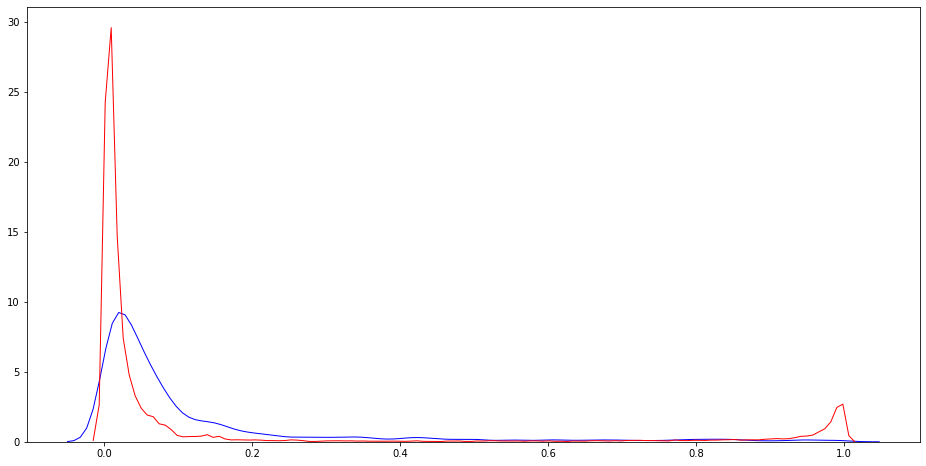

In [404]:

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.figure(figsize=(16, 8))
sns.distplot(lista_probas_0, hist=False, kde=True, 
             bins=int(180/5), color = 'blue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 1})
sns.distplot(lista_probas_1, hist=False, kde=True, 
             bins=int(180/5), color = 'red', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 1})

In [405]:
media = statistics.mean(lista_probas_1)
dp = statistics.stdev(lista_probas_1) / 2
print('\nTestes com tratamento da classe 0 com média/dp\n')
df_test = calcula_classes(df_test,media=media,dp=dp)
conferencia_validacao(df_test, '')
conferencia_validacao(df_test, '!=0')
df_conf = conferencia_validacao(df_test, '==0')
df_conf[df_conf['bot_id_test'] == 0]


Testes com tratamento da classe 0 com média/dp

Métricas de Desempenho do VotingClassifier - Todos:
Total de Registros Considerados: 1683 ( 100.0 %)
Acurácia: 0.7861 - Precisão (Macro): 0.6811 - Recall (Macro): 0.778 - F1 (Macro): 0.7249 - F1 (Weighted): 0.7212
------------------------------------------------------------------------------------------------------------------------
Métricas de Desempenho do VotingClassifier - Somente bot_id != 0:
Total de Registros Considerados: 1428 ( 84.8485 %)
Acurácia: 0.9265 - Precisão (Macro): 0.9253 - Recall (Macro): 0.8753 - F1 (Macro): 0.8983 - F1 (Weighted): 0.9249
------------------------------------------------------------------------------------------------------------------------
Métricas de Desempenho do VotingClassifier - Somente bot_id == 0:
Total de Registros Considerados: 255 ( 15.1515 %)
Acurácia: 0.0 - Precisão (Macro): 0.0 - Recall (Macro): 0.0 - F1 (Macro): 0.0 - F1 (Weighted): 0.0
-------------------------------------------------

,id,bot_id_verdade,pergunta,proba_vc_1,proba_vc_2,proba_vc_3,proba_vc_4,proba_vc_5,proba_vc_6,proba_vc_7,proba_vc_8,bot_id_test


## A melhor solução até agora
Conta número de palavras fora do vocabulário. Se existir um número maior do que um limite, seta bot_id = 0, **desde que a probabilidade da classe definida originalmente seja menor que um determinado limite**

In [406]:
limite_palavras_fora_do_vocabulario = 2
limite_minimo_probabilidade_classe_original = 0.68 # 0.73

if vocabulario != None:  
    df_test = calcula_classes(df_test,media=media,dp=dp)
    
    conferencia_validacao(df_test, '')
    conferencia_validacao(df_test, '!=0')
    df_conf = conferencia_validacao(df_test, '==0')
    print('-'*120,'\n')
    
    for index, row in df_test.iterrows():
        
        if df_test.at[index,'proba_vc_' + str(df_test.at[index,'bot_id'])] > limite_minimo_probabilidade_classe_original:
            continue
 
        tokens = tokenizer.tokenize(df_test.at[index,'pergunta'])
        total_palavras = len(tokens)
        tokens = [palavra for palavra in tokens if palavra not in vocabulario] 

        if len(tokens) > limite_palavras_fora_do_vocabulario:
            df_test.at[index,'bot_id'] = 0
            
    conferencia_validacao(df_test, '')
    conferencia_validacao(df_test, '!=0')
    df_conf = conferencia_validacao(df_test, '==0')

print(len(df_conf[df_conf['bot_id_test'] == 0]  ))
df_conf[df_conf['bot_id_test'] == 0]    

Métricas de Desempenho do VotingClassifier - Todos:
Total de Registros Considerados: 1683 ( 100.0 %)
Acurácia: 0.7861 - Precisão (Macro): 0.6811 - Recall (Macro): 0.778 - F1 (Macro): 0.7249 - F1 (Weighted): 0.7212
------------------------------------------------------------------------------------------------------------------------
Métricas de Desempenho do VotingClassifier - Somente bot_id != 0:
Total de Registros Considerados: 1428 ( 84.8485 %)
Acurácia: 0.9265 - Precisão (Macro): 0.9253 - Recall (Macro): 0.8753 - F1 (Macro): 0.8983 - F1 (Weighted): 0.9249
------------------------------------------------------------------------------------------------------------------------
Métricas de Desempenho do VotingClassifier - Somente bot_id == 0:
Total de Registros Considerados: 255 ( 15.1515 %)
Acurácia: 0.0 - Precisão (Macro): 0.0 - Recall (Macro): 0.0 - F1 (Macro): 0.0 - F1 (Weighted): 0.0
--------------------------------------------------------------------------------------------------

,id,bot_id_verdade,pergunta,proba_vc_1,proba_vc_2,proba_vc_3,proba_vc_4,proba_vc_5,proba_vc_6,proba_vc_7,proba_vc_8,bot_id_test
36,36,0,mulh jov tamb esta alv doenc,0.063328,0.026932,0.027105,0.600826,0.044807,0.120228,0.013660,0.021453,0
54,54,0,proib vend beb alcool bar restaurant dia eleica,0.110158,0.218282,0.030033,0.145978,0.096535,0.062365,0.023547,0.007824,0
65,65,0,pic mosquit unic form transmissa deng,0.032677,0.037210,0.465249,0.029093,0.037638,0.035240,0.017648,0.020517,0
73,73,0,incidenc hipertensa aument publ jov,0.037437,0.064821,0.225940,0.121053,0.094698,0.132275,0.111456,0.038329,0
81,81,3,poss us googl chrom mozill firefox safar oper ...,0.055150,0.017732,0.302777,0.370972,0.014336,0.063139,0.036211,0.004412,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1605,1605,0,benefici prestaca continu assistenc soc bpc loa,0.159444,0.025414,0.088452,0.022861,0.135936,0.449154,0.075145,0.008311,0
1608,1608,0,desd ont noit compilaca final program delet to...,0.105895,0.018764,0.068966,0.624578,0.021718,0.089076,0.010193,0.006387,0
1611,1611,0,metad vot nul branc eleica anul,0.065343,0.071028,0.084519,0.154012,0.138266,0.087973,0.064993,0.011285,0
1614,1614,0,commit err nao identific complexific merg inte...,0.034035,0.027816,0.589845,0.048117,0.038084,0.434122,0.004720,0.007106,0


In [407]:
df_conf[(df_conf['bot_id_test'] == 0) & (df_conf['bot_id_verdade'] != 0)]  

,id,bot_id_verdade,pergunta,proba_vc_1,proba_vc_2,proba_vc_3,proba_vc_4,proba_vc_5,proba_vc_6,proba_vc_7,proba_vc_8,bot_id_test
81,81,3,poss us googl chrom mozill firefox safar oper ...,0.055150,0.017732,0.302777,0.370972,0.014336,0.063139,0.036211,0.004412,0
807,807,7,certific codig qr cod situaca regul,0.167523,0.025101,0.170121,0.131863,0.040901,0.041842,0.085850,0.007691,0
1168,1168,3,nao consig segu cadastr inform cep inval neces...,0.015281,0.004555,0.629158,0.033921,0.003733,0.073121,0.210330,0.004862,0
1298,1298,8,beij tamb nao caus transmissa doenc,0.017554,0.025093,0.114143,0.420859,0.036956,0.101056,0.012065,0.039832,0
1503,1503,1,brasil pod escolh forc arm qu prest serv milit,0.601657,0.027930,0.007692,0.008517,0.011199,0.037570,0.150246,0.004752,0


In [408]:
'''
Sem stemmer

limite_palavras_fora_do_vocabulario = 2
limite_minimo_probabilidade_classe_original = 0.73


Métricas de Desempenho do VotingClassifier - Todos:
Total de Registros Considerados: 1683 ( 100.0 %)
Acurácia: 0.7825 - Precisão: 0.6659 - Recall: 0.7825 - F1 (Macro): 0.7181
------------------------------------------------------------------------------------------------------------------------
Métricas de Desempenho do VotingClassifier - Somente bot_id != 0:
Total de Registros Considerados: 1428 ( 84.8485 %)
Acurácia: 0.9223 - Precisão: 0.9211 - Recall: 0.9223 - F1 (Macro): 0.9202
------------------------------------------------------------------------------------------------------------------------
Métricas de Desempenho do VotingClassifier - Somente bot_id == 0:
Total de Registros Considerados: 255 ( 15.1515 %)
Acurácia: 0.0 - Precisão: 0.0 - Recall: 0.0 - F1 (Macro): 0.0
------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------ 

Métricas de Desempenho do VotingClassifier - Todos:
Total de Registros Considerados: 1683 ( 100.0 %)
Acurácia: 0.8301 - Precisão: 0.8323 - Recall: 0.8301 - F1 (Macro): 0.8114
------------------------------------------------------------------------------------------------------------------------
Métricas de Desempenho do VotingClassifier - Somente bot_id != 0:
Total de Registros Considerados: 1428 ( 84.8485 %)
Acurácia: 0.9181 - Precisão: 0.9276 - Recall: 0.9181 - F1 (Macro): 0.9211
------------------------------------------------------------------------------------------------------------------------
Métricas de Desempenho do VotingClassifier - Somente bot_id == 0:
Total de Registros Considerados: 255 ( 15.1515 %)
Acurácia: 0.3373 - Precisão: 1.0 - Recall: 0.3373 - F1 (Macro): 0.5044
------------------------------------------------------------------------------------------------------------------------

'''

'\nSem stemmer\n\nlimite_palavras_fora_do_vocabulario = 2\nlimite_minimo_probabilidade_classe_original = 0.73\n\n\nMétricas de Desempenho do VotingClassifier - Todos:\nTotal de Registros Considerados: 1683 ( 100.0 %)\nAcurácia: 0.7825 - Precisão: 0.6659 - Recall: 0.7825 - F1 (Macro): 0.7181\n------------------------------------------------------------------------------------------------------------------------\nMétricas de Desempenho do VotingClassifier - Somente bot_id != 0:\nTotal de Registros Considerados: 1428 ( 84.8485 %)\nAcurácia: 0.9223 - Precisão: 0.9211 - Recall: 0.9223 - F1 (Macro): 0.9202\n------------------------------------------------------------------------------------------------------------------------\nMétricas de Desempenho do VotingClassifier - Somente bot_id == 0:\nTotal de Registros Considerados: 255 ( 15.1515 %)\nAcurácia: 0.0 - Precisão: 0.0 - Recall: 0.0 - F1 (Macro): 0.0\n----------------------------------------------------------------------------------------

In [409]:
'''
Sem stemmer
limite_palavras_fora_do_vocabulario = 2
limite_minimo_probabilidade_classe_original = 0.68 # 0.73

Métricas de Desempenho do VotingClassifier - Todos:
Total de Registros Considerados: 1683 ( 100.0 %)
Acurácia: 0.7825 - Precisão (Macro): 0.673 - Recall (Macro): 0.7762 - F1 (Macro): 0.7173 - F1 (Weighted): 0.7181
------------------------------------------------------------------------------------------------------------------------
Métricas de Desempenho do VotingClassifier - Somente bot_id != 0:
Total de Registros Considerados: 1428 ( 84.8485 %)
Acurácia: 0.9223 - Precisão (Macro): 0.9188 - Recall (Macro): 0.8733 - F1 (Macro): 0.8939 - F1 (Weighted): 0.9202
------------------------------------------------------------------------------------------------------------------------
Métricas de Desempenho do VotingClassifier - Somente bot_id == 0:
Total de Registros Considerados: 255 ( 15.1515 %)
Acurácia: 0.0 - Precisão (Macro): 0.0 - Recall (Macro): 0.0 - F1 (Macro): 0.0 - F1 (Weighted): 0.0
------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------ 

Métricas de Desempenho do VotingClassifier - Todos:
Total de Registros Considerados: 1683 ( 100.0 %)
Acurácia: 0.8253 - Precisão (Macro): 0.809 - Recall (Macro): 0.8044 - F1 (Macro): 0.787 - F1 (Weighted): 0.8038
------------------------------------------------------------------------------------------------------------------------
Métricas de Desempenho do VotingClassifier - Somente bot_id != 0:
Total de Registros Considerados: 1428 ( 84.8485 %)
Acurácia: 0.9188 - Precisão (Macro): 0.8211 - Recall (Macro): 0.7709 - F1 (Macro): 0.7935 - F1 (Weighted): 0.9208
------------------------------------------------------------------------------------------------------------------------
Métricas de Desempenho do VotingClassifier - Somente bot_id == 0:
Total de Registros Considerados: 255 ( 15.1515 %)
Acurácia: 0.302 - Precisão (Macro): 0.125 - Recall (Macro): 0.0377 - F1 (Macro): 0.058 - F1 (Weighted): 0.4639
------------------------------------------------------------------------------------------------------------------------
90

'''

'\nSem stemmer\nlimite_palavras_fora_do_vocabulario = 2\nlimite_minimo_probabilidade_classe_original = 0.68 # 0.73\n\nMétricas de Desempenho do VotingClassifier - Todos:\nTotal de Registros Considerados: 1683 ( 100.0 %)\nAcurácia: 0.7825 - Precisão (Macro): 0.673 - Recall (Macro): 0.7762 - F1 (Macro): 0.7173 - F1 (Weighted): 0.7181\n------------------------------------------------------------------------------------------------------------------------\nMétricas de Desempenho do VotingClassifier - Somente bot_id != 0:\nTotal de Registros Considerados: 1428 ( 84.8485 %)\nAcurácia: 0.9223 - Precisão (Macro): 0.9188 - Recall (Macro): 0.8733 - F1 (Macro): 0.8939 - F1 (Weighted): 0.9202\n------------------------------------------------------------------------------------------------------------------------\nMétricas de Desempenho do VotingClassifier - Somente bot_id == 0:\nTotal de Registros Considerados: 255 ( 15.1515 %)\nAcurácia: 0.0 - Precisão (Macro): 0.0 - Recall (Macro): 0.0 - F1 (Mac